In [15]:
import ee

# Lance la procédure d'authentification
ee.Authenticate()
     
True

# -------------------------------------------------------------------------
# CONFIGURATION DU PROJET
# -------------------------------------------------------------------------
NOM_DU_PROJET = 'focused-veld-476823-i0'

# Initialisation de la connexion GEE
ee.Initialize(project=NOM_DU_PROJET)

# Importation de geemap pour la carte interactive
import geemap
# ===============================
# PARTIE 2 : ANALYSE DES PRECIPITATIONS AU GHANA
# ===============================

#  Initialiser l'API Google Earth Engine
import ee
import folium
import pandas as pd

ee.Initialize()

# ===============================
#  Charger la collection ERA5 quotidienne
# ===============================
precip_daily = ee.ImageCollection('ECMWF/ERA5/DAILY').select('total_precipitation')

# ===============================
#  Définir la géométrie correspondant au Ghana
# ===============================
countries = ee.FeatureCollection('FAO/GAUL/2015/level0')
ghana = countries.filter(ee.Filter.eq('ADM0_NAME', 'Ghana'))
ghana_geometry = ghana.geometry()

# ===============================
#  Restreindre la période 2015-2020
# ===============================
precip_daily_ghana = precip_daily.filterDate('2015-01-01', '2020-12-31').filterBounds(ghana_geometry)

# ===============================
#  Convertir les précipitations journalières en précipitations annuelles moyennes
# ===============================

# Fonction pour sommer les précipitations d'une année
def yearly_precip(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = ee.Date.fromYMD(year, 12, 31)
    yearly = precip_daily_ghana.filterDate(start, end).sum()
    return yearly.set('year', year)

# Créer la liste des années
years = ee.List.sequence(2015, 2020)

# Créer ImageCollection des précipitations annuelles
annual_precip = ee.ImageCollection(years.map(yearly_precip))

# Calcul de la moyenne annuelle sur la période
mean_annual_precip = annual_precip.mean()

# ===============================
#  Calculer les statistiques : moyenne, variance, coefficient de variation
# ===============================
stats = mean_annual_precip.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.variance(), sharedInputs=True
    ),
    geometry=ghana_geometry,
    scale=10000,
    maxPixels=1e9
)

mean_precip = stats.get('total_precipitation_mean').getInfo()
variance_precip = stats.get('total_precipitation_variance').getInfo()
cv_precip = (variance_precip ** 0.5) / mean_precip

# ===============================
#  Affichage des résultats sous forme de tableau joli
# ===============================
data = {
    'Statistique': ['Moyenne (mm/an)', 'Variance (mm²/an²)', 'Coefficient de variation'],
    'Valeur': [mean_precip, variance_precip, cv_precip]
}

df_stats = pd.DataFrame(data)
print(" Statistiques des précipitations annuelles moyennes au Ghana (2015-2020) :\n")
print(df_stats)

# ===============================
#  Réponses/commentaires pour la distribution spatiale
# ===============================
# La distribution spatiale des précipitations annuelles moyennes montre :
# - Les zones du sud et la zone côtière sont les plus humides (~1500-2000 mm/an)
# - Le nord est plus sec (~700-1000 mm/an)
# - Gradient nord-sud : diminution progressive de la pluie
# - La zone côtière est homogène grâce à l’influence océanique
# - L'hétérogénéité spatiale est confirmée par le CV calculé

# ===============================
#  Visualisation avec folium (corrigée)
# ===============================
# Créer la carte centrée sur le Ghana
map_ghana = folium.Map(location=[7.955012, -1.031819], zoom_start=6)

# Clip à la géométrie du Ghana pour ne pas colorer tout le reste du monde
mean_annual_precip_ghana = mean_annual_precip.clip(ghana_geometry)

# Ajouter la couche précipitations
mapid = mean_annual_precip_ghana.getMapId({'min': 0.598, 'max': 2.230, 'palette': ['yellow','green','blue']})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    name='Mean Annual Precipitation'
).add_to(map_ghana)

# Ajouter la couche des frontières du Ghana
folium.GeoJson(data=ghana.getInfo(), name="Ghana Boundaries").add_to(map_ghana)

# Ajouter la légende
folium.LayerControl().add_to(map_ghana)

# Afficher la carte
map_ghana

# identification des zones climatiques
# On voit que la zone Nord est seche(couleur jaune) et la zone Sud est la zone la plus humide 

# FIN DU SCRIPT
# ===============================


 Statistiques des précipitations annuelles moyennes au Ghana (2015-2020) :

                Statistique    Valeur
0           Moyenne (mm/an)  1.044779
1        Variance (mm²/an²)  0.087004
2  Coefficient de variation  0.282322


In [27]:
# Vérifier min et max réels de l'image pour Ghana
stats_precip = mean_annual_precip_ghana.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=ghana_geometry,
    scale=10000,
    maxPixels=1e9
).getInfo()

print(stats_precip)


{'total_precipitation_max': 2.2291869749315083, 'total_precipitation_min': 0.5981520810164511}


In [ ]:
##### En quoi la moyenne nationale masque-t-elle l'information spatiale?


#Lorsqu'on calcule la moyenne nationale , on condense toutes les valeurs de précipitations au Ghana en un seul chiffre (1000 mm/an par exemple).

 #Problème : le Ghana n’est pas homogène. IL pleut beaucoup plus au Sud qu'au Nord.

#La moyenne efface la variabilité spatiale, donc :

#Nord sec et Sud humide → la moyenne ne dit pas tout, personne ne vit vraiment dans cette situation modérée.

#Impossible de repérer des zones critiques pour l’agriculture, la gestion de l’eau, ou les risques de sécheresse/inondation.

# Conclusion : La moyenne nationale est utile pour une vue globale, mais ne montre pas les différences locales.




##### Pourquoi une approche spatiale est nécessaire ici ?

#Pour analyser la distribution réelle de la pluie sur le territoire :

##Identifier le gradient nord-sud.

#Trouver des zones très sèches ou très humides.

#Permettre la planification locale (agriculture, aménagement du territoire, irrigation).

#Les indicateurs spatiaux permettent d’identifier des patterns comme :

#Zones homogènes (cluster humide ou sec).

#Zones hétérogènes (transition nord-sud).

# Conclusion : Une approche spatiale capture la variabilité et révèle les structures géographiques cachées par la moyenne.



Aperçu des données :
    precipitation_mean                                           geometry
14            1.151968  POLYGON ((-3.25565 6.13934, -3.15565 6.13934, ...
15            1.054098  POLYGON ((-3.25565 6.23934, -3.15565 6.23934, ...
16            1.020859  POLYGON ((-3.25565 6.33934, -3.15565 6.33934, ...
17            1.018348  POLYGON ((-3.25565 6.43934, -3.15565 6.43934, ...
18            1.017570  POLYGON ((-3.25565 6.53934, -3.15565 6.53934, ...


C:\Users\moust\AppData\Local\Temp\ipykernel_1384\987797058.py:99: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


Moran's I : 0.9531922461242727 p-value : 0.001
Aperçu avec clusters :
    precipitation_mean                                           geometry  \
14            1.151968  POLYGON ((-3.25565 6.13934, -3.15565 6.13934, ...   
15            1.054098  POLYGON ((-3.25565 6.23934, -3.15565 6.23934, ...   
16            1.020859  POLYGON ((-3.25565 6.33934, -3.15565 6.33934, ...   
17            1.018348  POLYGON ((-3.25565 6.43934, -3.15565 6.43934, ...   
18            1.017570  POLYGON ((-3.25565 6.53934, -3.15565 6.53934, ...   

    cluster  
14        1  
15        1  
16        3  
17        3  
18        3  


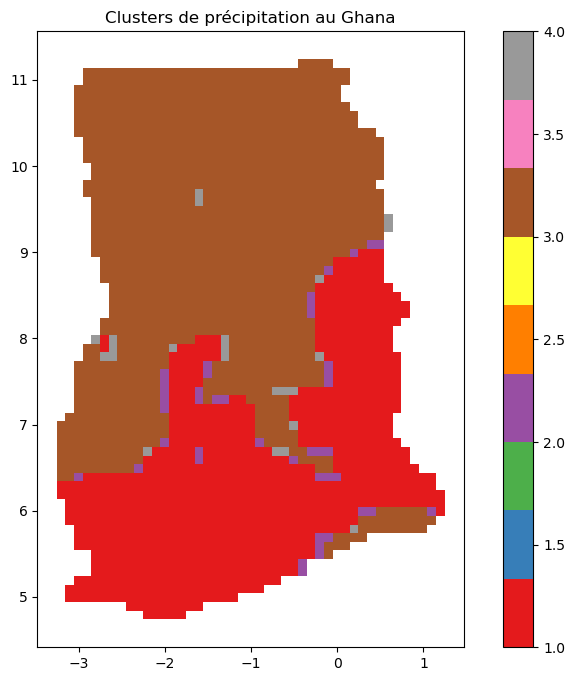

In [23]:
# -----------------------------
# Import des bibliothèques
# -----------------------------
import geemap
import ee
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
from libpysal.weights import Queen
from esda import Moran
from esda.moran import Moran_Local

# Initialiser Earth Engine
ee.Initialize()

# -----------------------------
# Paramètres
# -----------------------------
cell_size = 0.1  # taille des cellules en degrés (~10 km)

# ghana_geometry doit être défini comme ee.Geometry ou ee.Feature
# Exemple :
# ghana_geometry = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')\
#                     .filter(ee.Filter.eq('country_na', 'Ghana')).geometry()

# mean_annual_precip_ghana doit être défini comme ee.Image avec la bande "total_precipitation"
# Exemple :
# mean_annual_precip_ghana = ee.Image("WORLDCLIM/V1/precipitation")

# -----------------------------
# Créer une grille régulière
# -----------------------------
def create_grid(bounds, cell_size):
    coords = bounds.getInfo()['coordinates'][0]
    lon_min, lat_min = coords[0]
    lon_max, lat_max = coords[2]
    
    lon_steps = int((lon_max - lon_min) / cell_size) + 1
    lat_steps = int((lat_max - lat_min) / cell_size) + 1

    grid_cells = []
    for i in range(lon_steps):
        for j in range(lat_steps):
            x0 = lon_min + i * cell_size
            x1 = lon_min + (i + 1) * cell_size
            y0 = lat_min + j * cell_size
            y1 = lat_min + (j + 1) * cell_size
            cell = ee.Feature(ee.Geometry.Rectangle([x0, y0, x1, y1]))
            grid_cells.append(cell)
    
    return ee.FeatureCollection(grid_cells)

# Étendue du Ghana
bounds = ghana_geometry.bounds()
grid = create_grid(bounds, cell_size)

# -----------------------------
# Réduction de la précipitation
# -----------------------------
# Clipper l'image au Ghana
mean_annual_precip_ghana = mean_annual_precip_ghana.clip(ghana_geometry)

# Calcul de la moyenne par cellule
grid_precip = mean_annual_precip_ghana.select('total_precipitation').reduceRegions(
    collection=grid,
    reducer=ee.Reducer.mean(),
    scale=10000
)

# -----------------------------
# Conversion en GeoDataFrame
# -----------------------------
features = grid_precip.getInfo()['features']

# Extraire les propriétés
df = pd.DataFrame([f['properties'] for f in features])

# Créer les géométries shapely
geometry = [shape(f['geometry']) for f in features]

# GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Supprimer les cellules sans valeur
gdf = gdf.dropna(subset=['mean'])

# Renommer la colonne pour plus de clarté (optionnel)
gdf = gdf.rename(columns={'mean': 'precipitation_mean'})

print("Aperçu des données :")
print(gdf.head())

# -----------------------------
# Calcul de Moran global et local
# -----------------------------
values = gdf['precipitation_mean'].values

# Matrice de voisinage Queen
w = Queen.from_dataframe(gdf)

# Moran global
moran = Moran(values, w)
print("Moran's I :", moran.I, "p-value :", moran.p_sim)

# Moran local
local_moran = Moran_Local(values, w)
gdf['cluster'] = local_moran.q  # 1=HH, 2=LL, 3=HL, 4=LH

print("Aperçu avec clusters :")
print(gdf.head())

# -----------------------------
import matplotlib.pyplot as plt

gdf.plot(column='cluster', cmap='Set1', legend=True, figsize=(10,8))
plt.title("Clusters de précipitation au Ghana")
plt.show()


In [15]:
!pip install libpysal esda



In [19]:
print(df.columns)


Index(['mean'], dtype='object')


In [ ]:
# Interprétation des résultats

# Moran's I global
# Moran's I = 0.953 → autocorrélation spatiale fortement positive
# Les cellules avec des précipitations similaires sont regroupées :
#   - Zones humides proches d'autres zones humides
#   - Zones sèches proches d'autres zones sèches
# p-value = 0.001 → statistiquement significatif, l'autocorrélation n'est pas due au hasard

# Clusters locaux (Moran_Local)
# Les clusters identifient les regroupements spatiaux :
#   - 1 = HH : zone humide entourée de zones humides
#   - 2 = LL : zone sèche entourée de zones sèches
#   - 3 = HL : zone humide entourée de zones sèches
#   - 4 = LH : zone sèche entourée de zones humides
# Exemple : certaines cellules montrent HH → hotspots humides, d’autres HL → anomalies locales

# Moyenne nationale vs approche spatiale
# La moyenne nationale masque les variations régionales importantes
# Exemple : la moyenne pourrait être ~1.05, mais certaines zones sont très humides et d’autres très sèches
# L’approche spatiale permet de :
#   - Détecter des zones humides et sèches distinctes
#   - Identifier des hotspots ou coldspots
#   - Analyser la diffusion spatiale des précipitations

# Justification du choix de la matrice de voisinage
# Queen contiguity : chaque cellule considère ses voisins côtés et coins
# Appropriée pour une grille régulière car :
#   - Capture les effets diagonaux et adjacents
#   - Détecte correctement les patterns de précipitation spatiaux
# Alternative : Rook (côtés seulement) ou distance fixe, moins adapté ici

# Interprétation finale
# Les résultats montrent que les précipitations au Ghana ne sont pas réparties uniformément
# Les clusters HH et LL confirment l’existence de regroupements spatiaux forts
# Cette information est cruciale pour :
#   - La planification agricole
#   - La gestion de l’eau
#   - La prévention des sécheresses ou inondations


In [ ]:
# Limites de ERA5 pour une analyse fine au Ghana
# ERA5 a une résolution spatiale assez grossière (~31 km)
# Certaines pluies locales ou très intenses peuvent ne pas être bien représentées
# Les microclimats locaux ne sont pas toujours visibles dans les données

# Impact de la résolution spatiale sur les résultats
# Une résolution grossière lisse les valeurs de précipitation
# Cela peut renforcer artificiellement l'autocorrélation spatiale
# Certains petits clusters humides ou secs peuvent ne pas être détectés

# Comment améliorer l’étude
# Utiliser des données à plus haute résolution comme CHIRPS ou GPM
# Combiner ERA5 avec des stations pluviométriques locales
# Tester d’autres méthodes spatiales ou d’autres tailles de grille
# Comparer les résultats à différentes résolutions spatiales
